## Day 28 Lecture 1 Assignment

In this assignment, we will learn about making predictions with linear models. We will use the king county housing dataset loaded below and analyze the regression from this dataset.

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import bartlett
from scipy.stats import levene
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pylab
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [2]:
king_county = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/kc_house_data.csv')

In [3]:
king_county.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


We'll start by filtering out columns and keeping only: price, bedrooms, bathrooms, sqft_living, floors, and waterfront.

In [4]:
# answer below:
df = king_county[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront']]
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
0,221900.0,3,1.00,1180,1.0,0
1,538000.0,3,2.25,2570,2.0,0
2,180000.0,2,1.00,770,1.0,0
3,604000.0,4,3.00,1960,1.0,0
4,510000.0,3,2.00,1680,1.0,0


Next create a pair plot in Seaborn to see the relationships between your features.

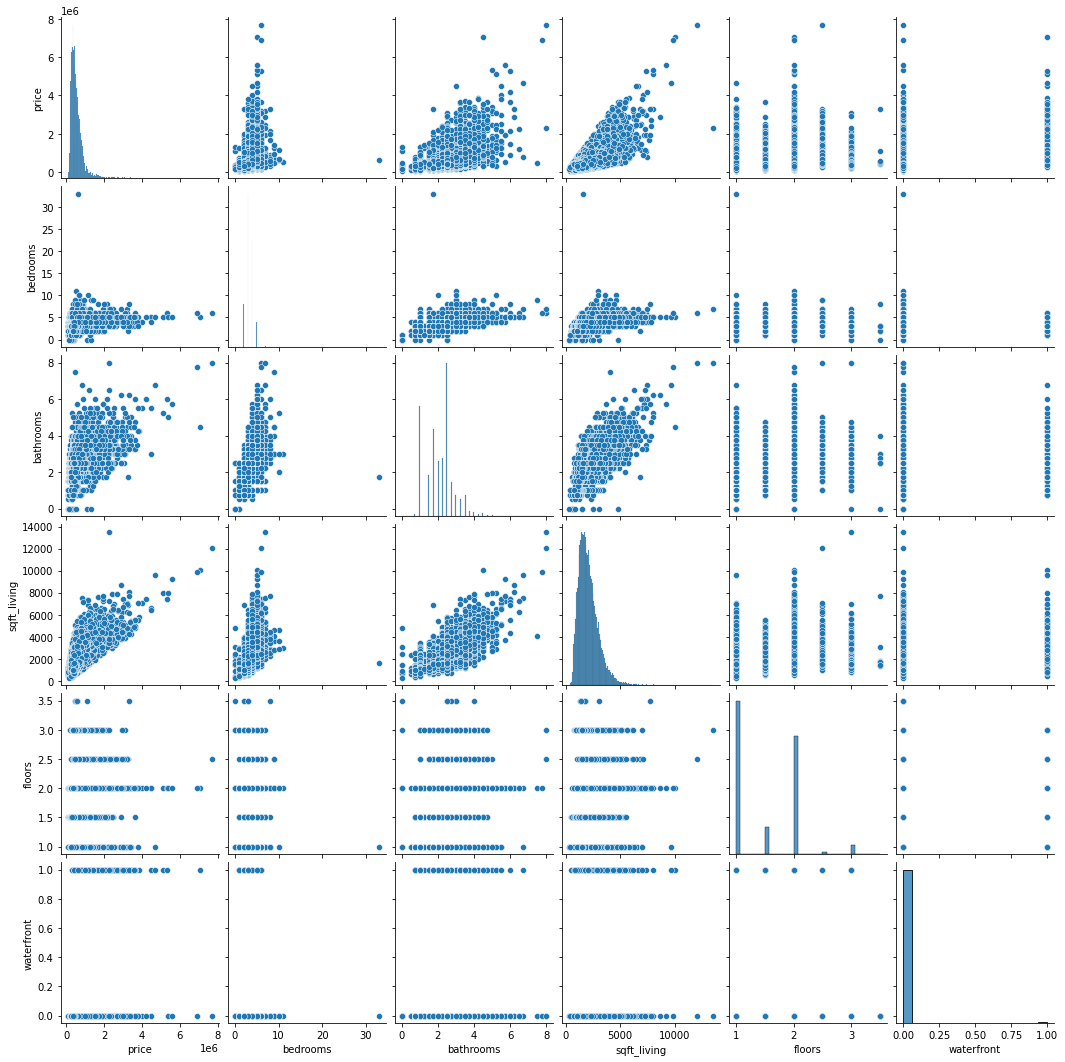

In [5]:
# answer below:
sns.pairplot(df)


In [51]:
for column in df.columns:
  print(f'Values for {column} column', df[column].value_counts())

Values for price column 450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
641500.0      1
575950.0      1
674250.0      1
608700.0      1
884744.0      1
Name: price, Length: 4027, dtype: int64
Values for bedrooms column 3     9824
4     6882
2     2760
5     1601
6      271
1      199
7       38
8       13
0       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64
Values for bathrooms column 2.50    5380
1.00    3852
1.75    3047
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.25       2
6.50       2
6.75       2
7.50       1
8.00       1
7.75       1
Name: bathrooms, dtype: int64
Values for sqft_living column 1300    138
1400    135
1440    133
1010    129
1660    129
       ... 
3065      1
3001      

There are two noticeable outliers here that will cause problems. Remove them.

In [6]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [13]:
df = df[df.bedrooms != 33]
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

{'boxes': [<matplotlib.lines.Line2D at 0x7fae26f12518>],
 'caps': [<matplotlib.lines.Line2D at 0x7fae26f12f28>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fae26e9f9e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fae26e9f668>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fae26f12828>,
  <matplotlib.lines.Line2D at 0x7fae26f12ba8>]}

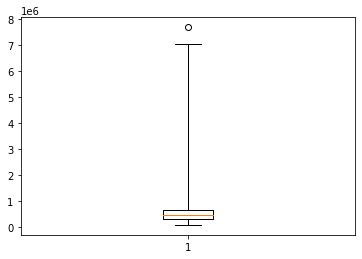

In [27]:
plt.boxplot(df.price, whis=20)

In [31]:
df.price.sort_values(ascending=True)

1149       75000.0
15293      78000.0
465        80000.0
16198      81000.0
8274       82000.0
           ...    
1448     5350000.0
4411     5570000.0
9254     6885000.0
3914     7062500.0
7252     7700000.0
Name: price, Length: 21612, dtype: float64

In [32]:
df = df[df.price != 7700000.0]

{'boxes': [<matplotlib.lines.Line2D at 0x7fae26e2bc18>],
 'caps': [<matplotlib.lines.Line2D at 0x7fae26e39668>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fae26e44128>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fae26e39d68>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fae26e2bf28>,
  <matplotlib.lines.Line2D at 0x7fae26e392e8>]}

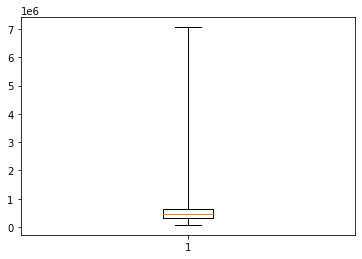

In [34]:
plt.boxplot(df.price, whis=20)

Next, we'll check for missing values and remove rows containing missing values. We will also make sure that all our data is numeric and convert the columns that are of object type to numeric. Make sure to remove any rows with missing data resulting from the conversion to numeric.

In [25]:
# answer below:
df.isnull().sum()
#there are no missing values


price          0
bedrooms       0
bathrooms      0
sqft_living    0
floors         0
waterfront     0
dtype: int64

In [36]:
df.dtypes

price          float64
bedrooms         int64
bathrooms      float64
sqft_living      int64
floors         float64
waterfront       int64
dtype: object

Split the data into test and train subsets. Use 20% of the data for the test subset. Use price as the dependent variable.

In [39]:
# answer below:
x = df.drop(columns=['price'])
x = sm.add_constant(x)
y = df.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
results = sm.OLS(y_train, x_train)
fit = results.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     4177.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:07:44   Log-Likelihood:            -2.3914e+05
No. Observations:               17288   AIC:                         4.783e+05
Df Residuals:                   17282   BIC:                         4.783e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.487e+04   8347.769      8.969      

Check the model assumptions: homoscedacity, normal errors, and multicollinearity

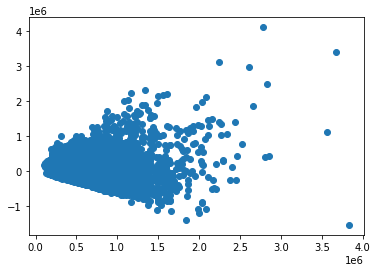

Bartlett stats: BartlettResult(statistic=154.6324164795782, pvalue=1.68470029210711e-35)
Levene stats: LeveneResult(statistic=156.48501878831857, pvalue=7.93097497270707e-36)


In [43]:
prediction = fit.predict(x_train)
residual = (y_train - prediction)

bart_stats = bartlett(residual, prediction)
lev_stats = levene(residual, prediction)

plt.scatter(prediction, residual)
plt.show()

print('Bartlett stats:', bart_stats)
print('Levene stats:', lev_stats)

In [45]:
jarque_stats = jarque_bera(residual)
norm_stats = normaltest(residual)

print('Jarque stats', jarque_stats)
print('Normal stats', norm_stats)

Jarque stats (261466.4067301273, 0.0)
Normal stats NormaltestResult(statistic=9958.309545979157, pvalue=0.0)


In [46]:
df.drop(columns='price').corr()

,bedrooms,bathrooms,sqft_living,floors,waterfront
bedrooms,1.000000,0.528952,0.591742,0.180885,-0.006601
bathrooms,0.528952,1.000000,0.753899,0.500704,0.063859
sqft_living,0.591742,0.753899,1.000000,0.353996,0.104145
floors,0.180885,0.500704,0.353996,1.000000,0.023705
waterfront,-0.006601,0.063859,0.104145,0.023705,1.000000


Create your final linear model and produce a model summary. Look at the coefficients and interpret their meaning. How do each of them influence the final prediction?

In [47]:
# answer below
x2 = df.drop(columns=['price', 'floors', 'sqft_living'])
x2 = sm.add_constant(x2)
y2 = df.price
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2)


In [49]:
results2 = sm.OLS(y_train2, x_train2)
fit2 = results2.fit()
print(fit.summary())
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     4177.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:27:04   Log-Likelihood:            -2.3914e+05
No. Observations:               17288   AIC:                         4.783e+05
Df Residuals:                   17282   BIC:                         4.783e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.487e+04   8347.769      8.969      

Predict the y values for the test sample using our model above.

Plot the true vs. predicted values and compute the MAE, MSE, RMSE and MAPE. How accurate is our model?

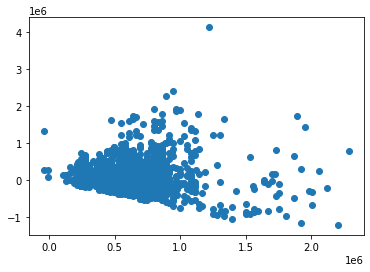

Bartlett stats: BartlettResult(statistic=383.9045543861241, pvalue=1.7574770927249837e-85)
Levene stats: LeveneResult(statistic=92.14235723663752, pvalue=1.0347633286038859e-21)


In [56]:
# answer below:
prediction2 = fit2.predict(x_test2)
residual2 = (y_test2 - prediction2)

bart_stats2 = bartlett(residual2, prediction2)
lev_stats2 = levene(residual2, prediction2)

plt.scatter(prediction2, residual2)
plt.show()

print('Bartlett stats:', bart_stats2)
print('Levene stats:', lev_stats2)


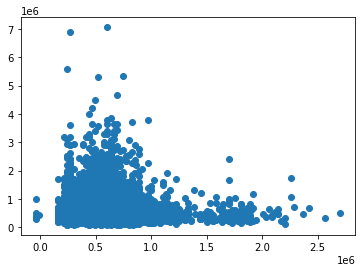

In [54]:
plt.scatter(prediction2, y_train)
plt.show()

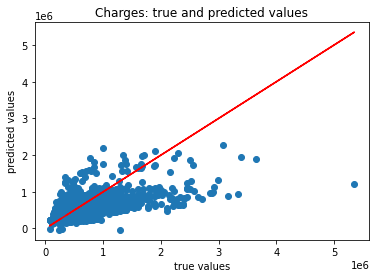

Mean absolute error of the prediction is: 201524.9080087448
Mean squared error of the prediction is: 89322109089.75032
Root mean squared error of the prediction is: 298868.0462842261
Mean absolute percentage error of the prediction is: 42.58850842567327


In [60]:
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tools.eval_measures import mse, rmse

plt.scatter(y_test2, prediction2)
plt.plot(y_test2, y_test2, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(meanabs(y_test2, prediction2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, prediction2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, prediction2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - prediction2) / y_test2)) * 100))